In [1]:
import os
import numpy as np
import json
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import glob
import pandas as pd
# add ../scripts/ to path and import scripts/utils.py
import sys
sys.path.append('../scripts/')
from utils import Location, Bible

def load(file):
    with gzip.open(file, "rb") as ifd:
            data = [json.loads(line) for line in ifd]
    return data

def create_array(score_files, threshold):
    data = {}
    for score_file in score_files:
        scores = load(score_file)
        df = pd.DataFrame.from_records(scores)
        
        # group by i and keep the n with the largest score
        if "score" in df.columns:
            df = df.groupby("i").apply(lambda x: x.loc[x["score"].idxmax()]).reset_index(drop=True)
            locations = df['start'].apply(lambda x: Location(x))
            assert len(locations.values) == len(df['score'].values)
            data[score_file] = {'locations': locations.values, 'scores': df['score'].values.reshape(1,-1)[0],}
        # group by i and keep the n with the smallest p-value
        else:
            df["chiasm_length"] = df["p"].apply(lambda x: 1 if x < threshold else 0)
            df["chiasm_length"] *= df["n"]
            df = df.groupby("i").apply(lambda x: x.loc[x["p"].idxmin()]).reset_index(drop=True)
            locations = df['start'].apply(lambda x: Location(x))
            assert len(locations.values) == len(df['chiasm_length'].values)
            data[score_file] = {'locations': locations.values, 'lengths': df['chiasm_length'].values.reshape(1,-1)[0],}
    
    # filepath: (location, chiasm_length_at_location_i)
    return data

def find_extremes(array, n):
    # find the columns that have the largest variation
    # we do this by finding the standard deviation of each column
    # then we sort the columns by the standard deviation
    # then we take the top n columns
    # first convert array to binary. If values are > 1, set to 1
    array = np.where(array > 0, 1, 0)
    # make it a df 
    # array = pd.DataFrame(array)
    # print(array)
    # column-wise standard deviation
    stds = np.std(array, axis=0)
    # print(stds.shape)
    # print()
    # print(stds)
    # print()
    # print("high order")
    high = np.argsort(stds)[::-1][:n]
    # print(high)
    # find the columns that have the smallest variation
    # but we don't want to include the columns that are all 0
    # the problem is that the standard deviation of a column that is all 0 is 0
    # and the standard deviation of a column that is all 1 is 0
    # but we only want to include the columns that are all 1
    # so we will set the standard deviation of the columns that are all 0 to 10
    # drop columns of array that are all 0
    # instead of dealing with STD, just find columns that are all 1

    # array = pd.DataFrame(array)
    
    # # print()
    # # print("no all 0 columns")
    # # print(array)
    # for this, we actually want to sort by the sum of the column, not the standard deviation!
    sums = np.sum(array, axis=0)
    # print(sums)
    # want the highest sums first
    low = np.argsort(sums)[::-1][:n]
    # low = np.argsort(sums)[:n]
    # stds2 = np.std(array, axis=0)
    # # print()
    # # print("low order")
    # low = np.argsort(stds2)[:n]
    # # print(low)
    return high, low, #stds

def get_passages_for_inspection(high, array, files, trs, locations):
    table_data = []
    for i, starting_pos in enumerate(high):
        # print(i, starting_pos)
        # grabbing the column of the array
        column = array[:,starting_pos]
        # print(column)
        # print(len(column))
        # j is the index of the file, k is the chiasm size
    
        for translation_idx, chiasm_length in enumerate(column):
            # print(translation_idx, chiasm_length)
            # j is the index of the file, k is the chiasm size
            file_name = files[translation_idx]
            bible = trs[file_name.split('-chiasm')[0]]
            if chiasm_length == 0:
                passage_length = 10
            else:
                passage_length = chiasm_length
            # assert chiasm_length > 0
            # print(f"using bible {file_name.split('-chiasm')[0]} to translate {file_name}")
            verses = locations[translation_idx][starting_pos: starting_pos+passage_length]
            text = ""
            for verse in verses:
                text += verse["book"]+ "." + str(verse["chapter"])+ "." +str(verse["verse"])+ "." + " "
                text += bible[verse] + " "
            # print(files.iloc[translation_idx])
            # # print(trs[file_name.split('-chiasm')[0]].data[:5])
            # print(trs[file_name.split('-chiasm')[0]].get_passage(start=i, end=i+chiasm_length, sep=''))
            # text = trs[file_name.split('-chiasm')[0]].get_passage(start=i, end=i+chiasm_length, sep='')
        
            table_data.append([i, file_name, starting_pos, chiasm_length, text])
        
    # make a dataframe
    return pd.DataFrame(table_data, columns=["index", "file", "starting_pos", "chiasm_length", "text"])




In [22]:
for manuscript in ['new_Sinaiticus-Greek', 'old_Sinaiticus-Greek', 'old_WLC-Hebrew']:
    score_files = glob.glob(f"../new_chiasm_scores/*{manuscript}*-chiasm.json.gz")
    translation_files = glob.glob(f"../translations/*{manuscript}*.json.gz")
    print([f for f in score_files if 'original' in f])
    break

['../new_chiasm_scores/work_new_Sinaiticus-Greek_original_Greek-chiasm.json.gz']


In [96]:
with gzip.open("/Users/hope/Documents/10 Projects/14 PhD/14.01 GitHub/literary-translation/new_chiasm_scores/chiasm_scores_work_old_WLC-Hebrew_exclude_human_Swedish-chiasm.json.gz", "rb") as ifd:
    data = [json.loads(line) for line in ifd]
print(data[:5])

[{'n': 4, 'i': 0, 'p': 0.4085914085914086, 'start': {'book': 'GEN', 'chapter': 1, 'verse': 1}, 'end': {'book': 'GEN', 'chapter': 1, 'verse': 4}}, {'n': 4, 'i': 1, 'p': 0.04895104895104895, 'start': {'book': 'GEN', 'chapter': 1, 'verse': 2}, 'end': {'book': 'GEN', 'chapter': 1, 'verse': 5}}, {'n': 4, 'i': 2, 'p': 0.057942057942057944, 'start': {'book': 'GEN', 'chapter': 1, 'verse': 3}, 'end': {'book': 'GEN', 'chapter': 1, 'verse': 6}}, {'n': 4, 'i': 3, 'p': 0.07292707292707293, 'start': {'book': 'GEN', 'chapter': 1, 'verse': 4}, 'end': {'book': 'GEN', 'chapter': 1, 'verse': 7}}, {'n': 4, 'i': 4, 'p': 0.00999000999000999, 'start': {'book': 'GEN', 'chapter': 1, 'verse': 5}, 'end': {'book': 'GEN', 'chapter': 1, 'verse': 8}}]


In [20]:

# for manuscript in ['new_Sinaiticus-Greek', 'old_Sinaiticus-Greek', 'old_WLC-Hebrew']:
for manuscript in ['old_BC', 'new_BC']:
    score_files = glob.glob(f"../chiasm_score_new_alg/*{manuscript}*-chiasm.json.gz")
    # print(score_files)
    # break
    translation_files = glob.glob(f"../translations/*{manuscript}*.json.gz")
    
    TRANSLATIONS = {}
    for file in translation_files:
        translation = Bible(file)
        TRANSLATIONS["_".join(os.path.basename(file).split("/")).split('.json.gz')[0]] = translation

    
    print(manuscript, len(score_files), len(translation_files))
    
    # try to load the pickle we saved
    try:
        import pickle
        with open(f"../data/{manuscript}_data_with_scores_new_alg.pkl", "rb") as ifd:
            data = pickle.load(ifd)
        print("Loaded data from pickle")
    except:
        threshold = 0.05
        data = create_array(score_files, threshold)
        # save the data to a file to reuse later
        # save it to a pickle
        print(data)
        import pickle
        with open(f"../data/{manuscript}_data_with_scores_new_alg.pkl", "wb") as ofd:
            pickle.dump(data, ofd)
        # exit()
    array = np.asarray([v['lengths'] for _,v in data.items()])
    print(array)
    # print(array.shape)
    locations = [v['locations'] for _,v in data.items()]
    # print([len(v['lengths']) for _,v in data.items()])
    
    # # print(stds)
    # # show subset with its columns ordered by high
    # # subset = subset[stds.argsort()[::-1]]
    # # print()
    # # print(subset)

    # # array = np.array(array)
    # # print(array.shape)
    # # print(data[score_files[0]])
    # high, low = find_extremes(array, 10)

    # # plt.scatter(range(len(stds)), stds)
    # # plt.show()
    # files = [os.path.basename(x) for x in score_files]
    # df = get_passages_for_inspection(low, array, files, TRANSLATIONS, locations)
    # # locations = [x[0].location for x in data[score_files[0]]]
    
    # df.to_csv(f"../data/{manuscript}_undisputed.csv", index=False)
    
    
    # print(f"Done with {manuscript}")

old_BC 6 6
{'../chiasm_score_new_alg/work_old_BC_human_translation_Japanese-chiasm.json.gz': {'locations': array([{'book': 'GEN', 'chapter': 1, 'verse': 1},
       {'book': 'GEN', 'chapter': 1, 'verse': 2},
       {'book': 'GEN', 'chapter': 1, 'verse': 3}, ...,
       {'book': 'MAL', 'chapter': 4, 'verse': 1},
       {'book': 'MAL', 'chapter': 4, 'verse': 2},
       {'book': 'MAL', 'chapter': 4, 'verse': 3}], dtype=object), 'lengths': array([0, 0, 0, ..., 0, 0, 0])}, '../chiasm_score_new_alg/work_old_BC_human_translation_Turkish-chiasm.json.gz': {'locations': array([{'book': 'GEN', 'chapter': 1, 'verse': 1},
       {'book': 'GEN', 'chapter': 1, 'verse': 2},
       {'book': 'GEN', 'chapter': 1, 'verse': 3}, ...,
       {'book': 'MAL', 'chapter': 4, 'verse': 1},
       {'book': 'MAL', 'chapter': 4, 'verse': 2},
       {'book': 'MAL', 'chapter': 4, 'verse': 3}], dtype=object), 'lengths': array([0, 0, 0, ..., 0, 0, 0])}, '../chiasm_score_new_alg/work_old_BC_human_translation_Swedish-chiasm

/Users/hope/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[array([0, 0, 0, ..., 0, 0, 0]) array([0, 0, 0, ..., 0, 0, 0])
 array([0, 0, 0, ..., 0, 0, 0]) array([0, 0, 0, ..., 5, 0, 0])
 array([0, 0, 0, ..., 0, 0, 0]) array([0, 0, 0, ..., 0, 0, 0])]
new_BC 6 6
{'../chiasm_score_new_alg/work_new_BC_human_translation_Turkish-chiasm.json.gz': {'locations': array([{'book': 'MAT', 'chapter': 1, 'verse': 1},
       {'book': 'MAT', 'chapter': 1, 'verse': 3},
       {'book': 'MAT', 'chapter': 1, 'verse': 4}, ...,
       {'book': 'REV', 'chapter': 22, 'verse': 16},
       {'book': 'REV', 'chapter': 22, 'verse': 17},
       {'book': 'REV', 'chapter': 22, 'verse': 18}], dtype=object), 'lengths': array([0, 0, 0, ..., 6, 4, 0])}, '../chiasm_score_new_alg/work_new_BC_human_translation_Swedish-chiasm.json.gz': {'locations': array([{'book': 'MAT', 'chapter': 1, 'verse': 1},
       {'book': 'MAT', 'chapter': 1, 'verse': 2},
       {'book': 'MAT', 'chapter': 1, 'verse': 3}, ...,
       {'book': 'REV', 'chapter': 22, 'verse': 16},
       {'book': 'REV', 'chapter'

In [34]:

for manuscript in ['old_BC', 'new_BC']:
    score_files = glob.glob(f"../new_chiasm_scores/*{manuscript}*-chiasm.json.gz")
    translation_files = glob.glob(f"../translations/*{manuscript}*.json.gz")
    
    TRANSLATIONS = {}
    for file in translation_files:
        translation = Bible(file)
        TRANSLATIONS["_".join(os.path.basename(file).split("/")).split('.json.gz')[0]] = translation

    
    print(manuscript, len(score_files), len(translation_files))
    # try loading from pickle
    try:
        import pickle
        with open(f"../data/{manuscript}_data.pkl", "rb") as ifd:
            data = pickle.load(ifd)
        print("Loaded data from pickle")
    except:
        exit()
        threshold = 0.05
        data = create_array(score_files, threshold)
        with open(f"../data/{manuscript}_data.pkl", "wb") as ofd:
            pickle.dump(data, ofd)
    array = np.asarray([v['lengths'] for _,v in data.items()])
    locations = [v['locations'] for _,v in data.items()]
    print([len(v['lengths']) for _,v in data.items()])

    array = np.array(array)
    print(array.shape)
    print(data[score_files[0]])
   
    # high = find_disputed(array, 10)
    # files = [os.path.basename(x) for x in score_files]
    # df = get_passages_for_inspection(high, array, files, TRANSLATIONS, locations)
    # # locations = [x[0].location for x in data[score_files[0]]]
    
    # df.to_csv(f"../data/{manuscript}_disputed.csv", index=False)
    
    # print(f"Done with {manuscript}")

old_BC 6 6
Loaded data from pickle
[23129, 22748, 23211, 23074, 23142, 22577]
(6,)
{'locations': array([{'book': 'GEN', 'chapter': 1, 'verse': 1},
       {'book': 'GEN', 'chapter': 1, 'verse': 2},
       {'book': 'GEN', 'chapter': 1, 'verse': 3}, ...,
       {'book': 'MAL', 'chapter': 4, 'verse': 1},
       {'book': 'MAL', 'chapter': 4, 'verse': 2},
       {'book': 'MAL', 'chapter': 4, 'verse': 3}], dtype=object), 'lengths': array([20, 20,  8, ...,  0,  0,  0])}


/Users/hope/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


new_BC 6 6
Loaded data from pickle
[7455, 7951, 7952, 7938, 7954, 7858]
(6,)
{'locations': array([{'book': 'MAT', 'chapter': 1, 'verse': 1},
       {'book': 'MAT', 'chapter': 1, 'verse': 3},
       {'book': 'MAT', 'chapter': 1, 'verse': 4}, ...,
       {'book': 'REV', 'chapter': 22, 'verse': 16},
       {'book': 'REV', 'chapter': 22, 'verse': 17},
       {'book': 'REV', 'chapter': 22, 'verse': 18}], dtype=object), 'lengths': array([7, 7, 5, ..., 0, 4, 0])}


In [7]:
# for file in chiasm_sore_new_alg, remove the '_new-alg' from their filename
# and then use the same code as above to get the data
import shutil

score_files = glob.glob(f"../chiasm_score_new_alg/*-chiasm*.json.gz")
for file in score_files:
    os.rename(file, file.replace('_new-alg', ''))

In [8]:
import glob
import pandas as pd
# I want to load in the 3 original score files, and then take the average of their chiasm lengths by book
# I can actually do this already. 
score_files = glob.glob(f"../chiasm_score_new_alg/*-chiasm.json.gz")
originals = [f for f in score_files if 'original' in f]
originals


['../chiasm_score_new_alg/work_old_WLC-Hebrew_original_Hebrew-chiasm.json.gz',
 '../chiasm_score_new_alg/work_old_Sinaiticus-Greek_original_Greek-chiasm.json.gz',
 '../chiasm_score_new_alg/work_new_Sinaiticus-Greek_original_Greek-chiasm.json.gz']

In [9]:
original_chiasms = []
for orig in originals:
    data = load(orig)
    df = pd.DataFrame.from_records(data)
    df['book'] = df['start'].apply(lambda x: Location(x)['book'])
    # there are multiple n values per i, so we only want to keep the one with the lowest p value
    df.groupby('i').apply(lambda x: x.loc[x['p'].idxmin()]).reset_index(drop=True)
    # drop rows where p < 0.01
    df = df[df['p']< 0.01]
    # print(df['n'].value_counts())
    # want to add 'n', 'book', 'lang' dataframe subset to original_chiasms
    lang = orig.split('/')[-1].split('_')[-1].replace('-chiasm.json.gz', '')
    df['lang'] = lang
    original_chiasms.append(df[['n', 'book', 'lang', 'candidate_score']])


In [10]:
#make a df of original_chiasms
original_chiasms_df = pd.concat(original_chiasms)
original_chiasms_df.head()


,n,book,lang,candidate_score
4,4,GEN,Hebrew,0.265326
16,4,GEN,Hebrew,0.228323
31,4,GEN,Hebrew,0.268274
48,4,GEN,Hebrew,0.210482
217,4,GEN,Hebrew,0.250494


<AxesSubplot:xlabel='book', ylabel='n'>

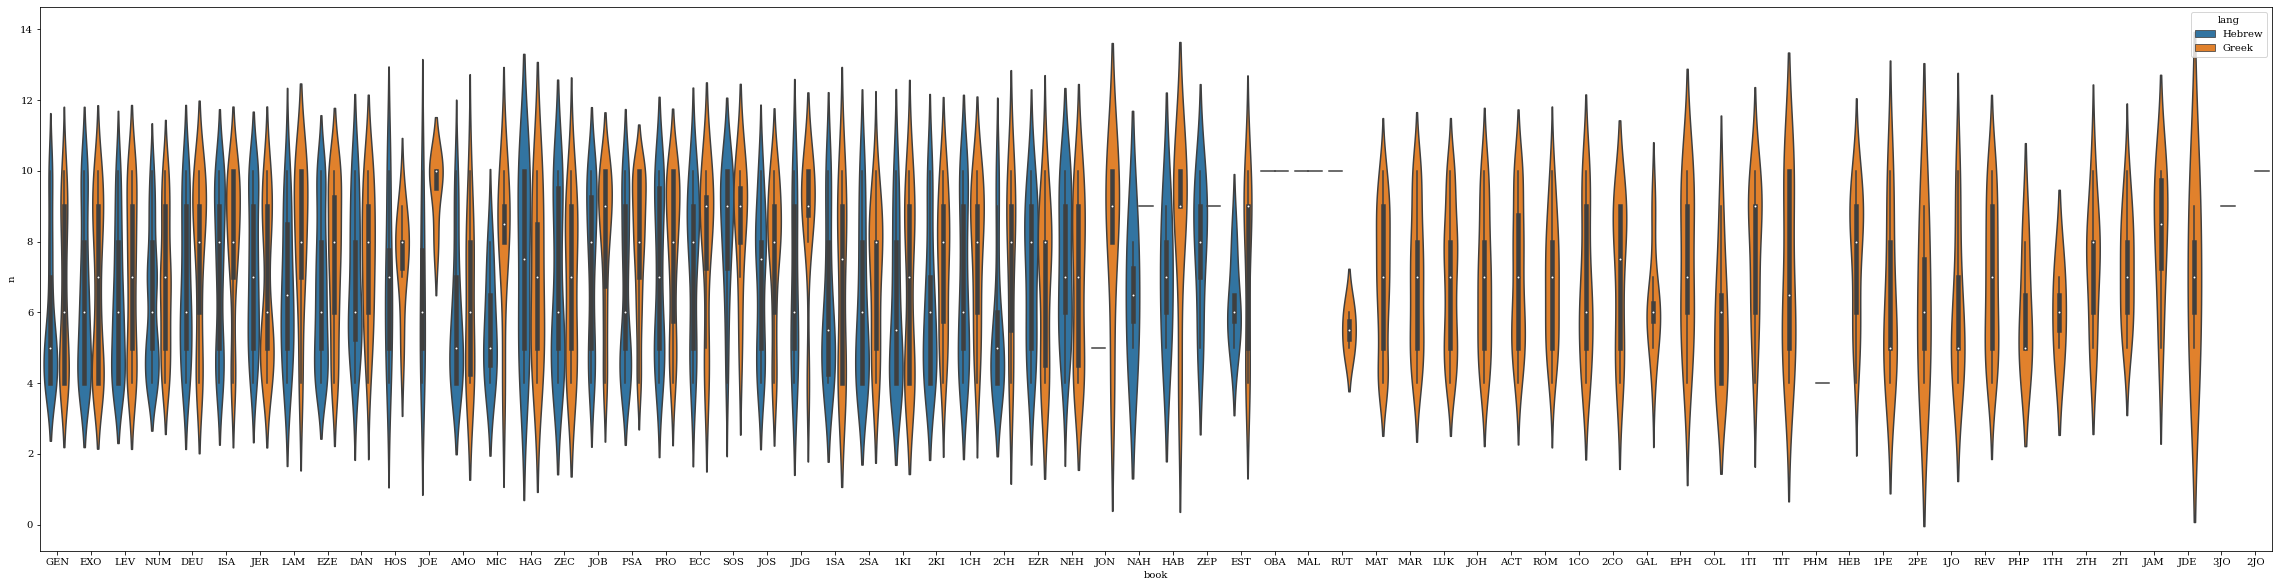

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# subset = original_chiasms_df[original_chiasms_df['book'].isin(['GEN', 'LEV', 'MAT', 'MAR', 'PSA', 'EXO'])]

ORDER = ["GEN", "EXO", "LEV", "NUM","DEU",
            "JOS","JDG", 'RUT','1SA','2SA','1KI', '2KI', '1CH', '2CH', 
            'EZR', 'NEH','EST', 'JOB', 'PSA', 'PRO', 'ECC', 'SOS', 
            'ISA', 'JER', 'LAM', 'EZE', 'DAN', 'HOS', 'JOE', 'AMO', 'OBA', 'JON', 'MIC', 'NAH', 'HAB', 'ZEP', 'HAG', 'ZEC', 'MAL',
            'MAT', 'MAR', 'LUK', 'JOH', 'ACT', 'ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'PHI', 'HEB', 'JAM', '1PE', '2PE', '1JO', '2JO', '3JO', 'JUD', 'REV']



# violin plot with lang as hue
plt.figure(figsize=(40,10))
sns.violinplot(original_chiasms_df, x='book', y='n',hue='lang' )



In [12]:
original_chiasms_df['n'].value_counts()

4     671
10    647
5     573
9     519
8     518
7     395
6     394
Name: n, dtype: int64

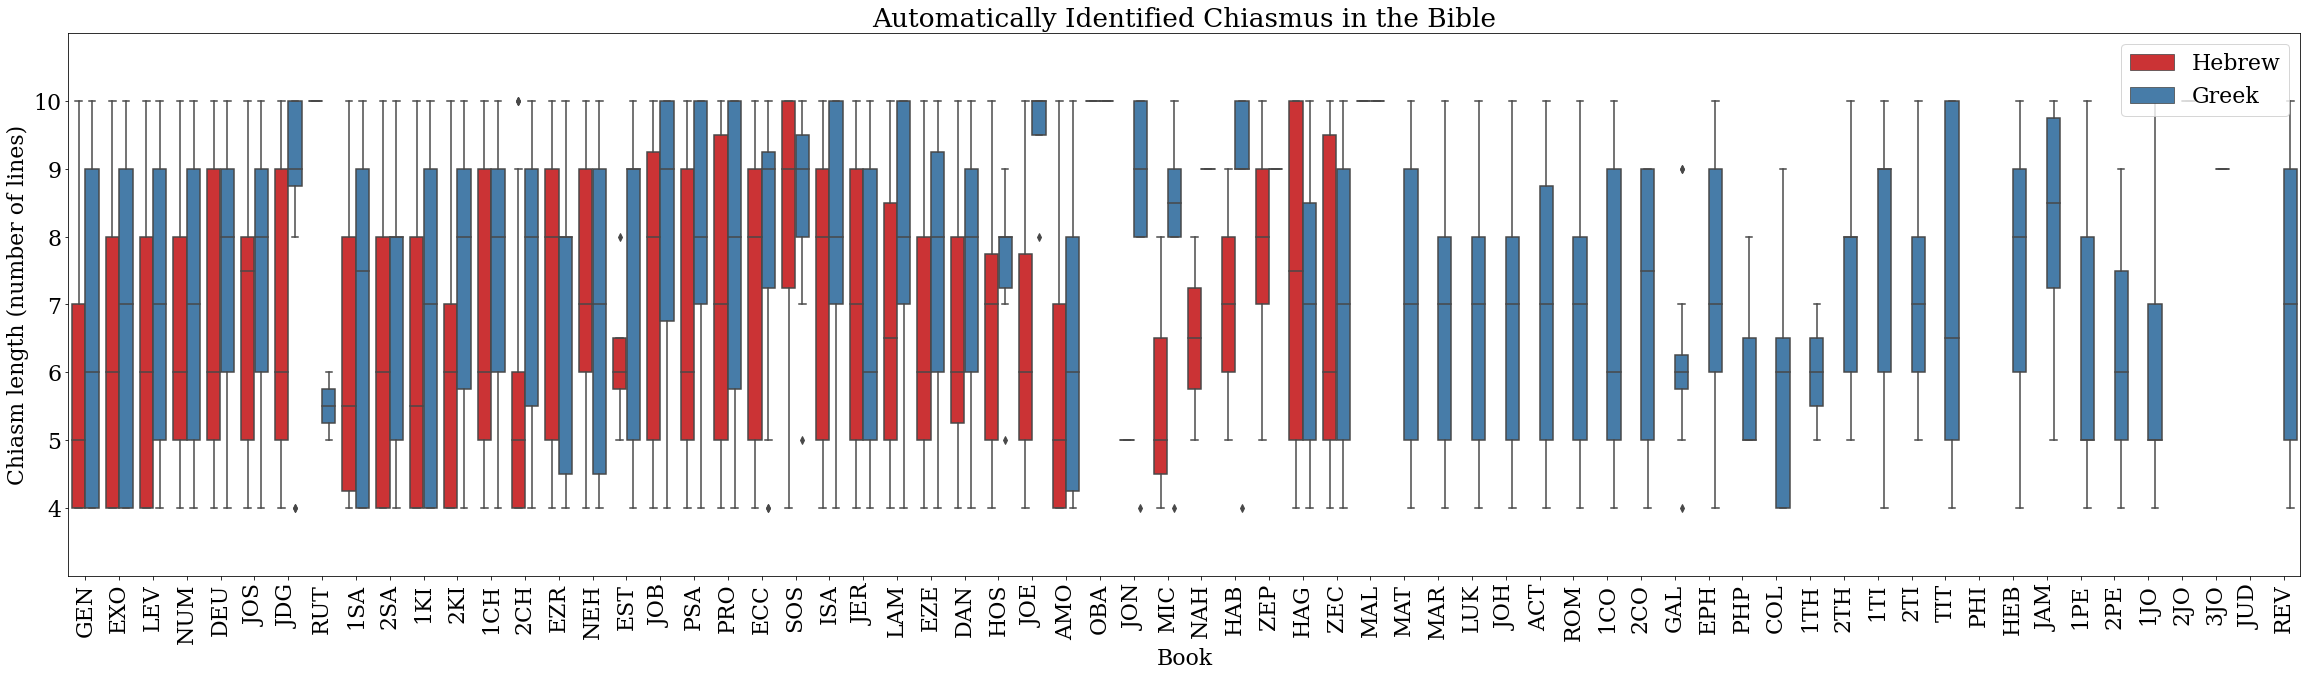

In [18]:
#violin plot ordered by ORDER
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22, 'font.family': 'serif'})

plt.figure(figsize=(40,10))
sns.boxplot(original_chiasms_df, x='book', y='n',hue='lang', order=ORDER, palette='Set1')
plt.ylim(3, 11)
plt.yticks(ticks=range(4,11, 1))
plt.xticks(rotation=90)
plt.xlabel('Book')
plt.ylabel('Chiasm length (number of lines)')
plt.title("Automatically Identified Chiasmus in the Bible")
plt.legend(loc='upper right')

plt.savefig('original_chiasms.pdf', bbox_inches="tight")

In [31]:
# want a table of how many even/odd chiasms are found in the Hebrew/Greek OT and the 
OT_ORDER = ORDER[:39]
NT_ORDER = ORDER[39:]

original_chiasms_df['testament'] = original_chiasms_df['book'].apply(lambda x: 'OT' if x in OT_ORDER else 'NT')
original_chiasms_df.head()

,n,book,lang,candidate_score,testament
4,4,GEN,Hebrew,0.265326,OT
16,4,GEN,Hebrew,0.228323,OT
31,4,GEN,Hebrew,0.268274,OT
48,4,GEN,Hebrew,0.210482,OT
217,4,GEN,Hebrew,0.250494,OT


In [32]:
def get_num(df, test, lang, even=True):
    if even:
        return df[(df['testament'] == test) &
                (df['lang'] == lang) &
                (df['n'] %2 == 0)]

    else:
        return df[(df['testament'] == test) &
                (df['lang'] == lang) &
                (df['n'] %2 == 1)]

len(get_num(original_chiasms_df, 'OT', 'Hebrew', even=True))



967

In [46]:
table_data = []
# we want the number of even and odd chiasms in each of these
table_data.append(['Even', len(get_num(original_chiasms_df, 'OT', 'Hebrew', even=True)),
                    len(get_num(original_chiasms_df, 'OT', 'Greek', even=True)),
                    len(get_num(original_chiasms_df, 'NT', 'Greek', even=True))])
table_data.append(['Odd', len(get_num(original_chiasms_df, 'OT', 'Hebrew', even=False)),
                    len(get_num(original_chiasms_df, 'OT', 'Greek', even=False)),
                    len(get_num(original_chiasms_df, 'NT', 'Greek', even=False))])
table_data.append(['Total', table_data[0][1]+ table_data[1][1],
                            table_data[0][2]+ table_data[1][2],
                            table_data[0][3]+ table_data[1][3]])

ot = original_chiasms_df['testament'] == 'OT'
nt = original_chiasms_df['testament'] == 'NT'
heb = original_chiasms_df['lang'] == 'Hebrew'
grk = original_chiasms_df['lang'] == 'Greek'

# heb = (df['testament'] == 'OT') & (df['lang'] == 'Hebrew')
# grk = (df['testament'] == 'OT') & (df['lang'] == 'Greek')
# nt = (df['testament'] == 'NT') & (df['lang'] == 'Greek')

# average length of chiasm
table_data.append(['Avg. Len', np.round(original_chiasms_df[ot& heb]['n'].mean(), 2),
                                np.round(original_chiasms_df[ot & grk]['n'].mean(), 2),
                                np.round(original_chiasms_df[nt & grk]['n'].mean(), 2)])
# most popular book
table_data.append(['Most Chiastic Book', original_chiasms_df[ot&heb]['book'].mode().tolist(),
                                original_chiasms_df[ot&grk]['book'].mode().tolist(),
                                original_chiasms_df[nt&grk]['book'].mode().tolist()]) 

# average score  
# average length of chiasm
table_data.append(['Max Chiasm Score', np.round(original_chiasms_df[ot&heb]['candidate_score'].max(), 2),
                                np.round(original_chiasms_df[ot&grk]['candidate_score'].max(), 2),
                                np.round(original_chiasms_df[nt&grk]['candidate_score'].max(), 2)])             



In [47]:
table_data

[['Even', 967, 888, 375],
 ['Odd', 634, 545, 308],
 ['Total', 1601, 1433, 683],
 ['Avg. Len', 6.67, 7.36, 6.94],
 ['Most Chiastic Book', ['NUM'], ['PSA'], ['LUK', 'MAT']],
 ['Max Chiasm Score', 0.55, 0.57, 0.38]]

In [48]:
import pytextable as pytex

pytex.write(table_data, 'chiasm_stats.tex', header=['type', 'OT Hebrew', 'OT Greek', 'NT'])


In [11]:
print(originals)

['../chiasm_score_full/work_old_WLC-Hebrew_original_Hebrew-chiasm.json.gz', '../chiasm_score_full/work_old_Sinaiticus-Greek_original_Greek-chiasm.json.gz', '../chiasm_score_full/work_new_Sinaiticus-Greek_original_Greek-chiasm.json.gz']


In [27]:
from utils import Bible

In [9]:


for orig in originals:
    top = 0
    orig_scores = []
    bible = Bible(orig.replace('chiasm_score_new_alg', 'translations').replace('-chiasm', ''))
    eng = Bible(orig.replace('chiasm_score_new_alg', 'translations').replace('-chiasm', '').replace('original', 'unconstrained').replace('_Hebrew', '_English').replace('_Greek', '_English'))
    # eng = Bible('../../narrative-analysis/work/english.jsonl')
    print(bible)
    print(eng)
    top_locs = {}
    data = load(orig)
    df = pd.DataFrame.from_records(data)
    df['id'] = df['start'].apply(lambda x: ".".join([Location(x)['book'], str(Location(x)['chapter'])]))

    # there are multiple n values per i, so we only want to keep the one with the lowest p value
    # just want to sort the df by score and take the top k=50
    df = df.sort_values('candidate_score', ascending=False)
    # print(df.head())
    for i, row in df.iterrows():
        if row['id'] not in top_locs.keys():
            top_locs[row['id']] = (row['start'], row['n'], row['candidate_score'])
            
            
            start_idx = bible.loc2idx[Location(row['start'])]
            # print(bible.idx2loc[start_idx])
            verses = [bible.data[i]["location"] for i in range(start_idx, start_idx+row['n'])]

            text = ""
            for verse in verses:
                text += verse["book"]+ "." + str(verse["chapter"])+ "." +str(verse["verse"])+ "." + " "
                text += bible[verse] + " "

            orig_scores.append({"num": top, "location": Location(row['start']), "length": row['n'], "score": row['candidate_score'], 
                        'translation': orig.split("/")[-1].split("-chiasm")[0],
                        'text': text})
            # now in English
            text = ""
            for verse in verses:
                text += verse["book"]+ "." + str(verse["chapter"])+ "." +str(verse["verse"])+ "." + " "
                text += eng[verse] + " "
            
            # print(orig_scores[-1])
            orig_scores.append({"num": top, "location": row['start'], "length": row['n'], "score": row['candidate_score'], 
                        'translation': eng.filename.split("/")[-1].split("-chiasm")[0], "text": text})
            
            # print(orig_scores[-1])
            top += 1
        if top >= 50:
            # make a df and then save to csv
            pd.DataFrame.from_records(orig_scores).to_csv(f"{orig.split('/')[-1]}_new-alg".replace("-chiasm", '').replace('.json.gz', '.csv'), index=False)
            print(f"Saved {orig.split('/')[-1]} to file")
            break

    
    # orig_scores.append(top_locs)
    # df.groupby('i').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)
    # # drop rows where p < 0.05
    # df = df[df['p']< 0.01]
    # # print(df['n'].value_counts())
    # # want to add 'n', 'book', 'lang' dataframe subset to original_chiasms
    # lang = orig.split('/')[-1].split('_')[-1].replace('-chiasm.json.gz', '')
    # df['lang'] = lang
    # orig_scores.append(df[['n', 'book', 'lang']])


Bible(../translations/work_old_WLC-Hebrew_original_Hebrew.json.gz)
Bible(../translations/work_old_WLC-Hebrew_unconstrained_English.json.gz)
Saved work_old_WLC-Hebrew_original_Hebrew-chiasm.json.gz to file
Bible(../translations/work_old_Sinaiticus-Greek_original_Greek.json.gz)
Bible(../translations/work_old_Sinaiticus-Greek_unconstrained_English.json.gz)
Saved work_old_Sinaiticus-Greek_original_Greek-chiasm.json.gz to file
Bible(../translations/work_new_Sinaiticus-Greek_original_Greek.json.gz)
Bible(../translations/work_new_Sinaiticus-Greek_unconstrained_English.json.gz)
Saved work_new_Sinaiticus-Greek_original_Greek-chiasm.json.gz to file
